In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split

import hervpd as hp
import plotReport as pr

## 1. Data description

In [2]:
# DATA_PATH = '/home/ju/GDrive/Projects/HeRV/Data/PreProcessed/'
DATA_PATH = "C:\\Users\\ju\\GDrive\\Projects\\HeRV\\Data\\PreProcessed\\" 
filename = DATA_PATH + 'df_90_300.xlsx'
df = pd.read_excel(filename)
df.describe()

,hf,hfnu,lf,lf_hf,lfnu,mhr,mrri,nn50,order,pnn50,rmssd,sdnn,sess,total_power,user,vlf
count,2.694000e+03,2694.000000,2.694000e+03,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2.694000e+03,2694.000000,2.694000e+03
mean,2.387300e+04,45.815472,4.127698e+05,2.465940,54.184528,78.661621,819.019148,89.473645,18.990720,25.773847,112.382566,114.926574,162.705642,1.475527e+06,1.624722,1.038884e+06
std,1.821238e+05,23.079335,8.977828e+06,4.822733,23.079335,18.109035,173.770072,71.387172,24.864286,22.689257,169.919067,122.765916,117.628292,4.585638e+07,2.009594,3.707927e+07
min,5.751146e-01,1.419545,2.567078e+00,0.027289,2.656368,47.596407,334.157205,0.000000,0.000000,0.000000,3.369205,13.625541,0.000000,3.390064e+01,0.000000,2.559104e+01
25%,3.727382e+02,26.437869,5.863960e+02,0.563744,36.050930,66.002474,703.884813,30.000000,2.000000,7.290387,33.034351,53.887830,63.000000,1.761790e+03,0.000000,5.059374e+02
50%,9.172297e+02,43.726407,1.280138e+03,1.286951,56.273593,77.199486,793.543971,72.000000,7.000000,18.870437,53.744197,77.456919,135.000000,3.576149e+03,1.000000,1.088380e+03
75%,4.668043e+03,63.949070,3.023524e+03,2.782454,73.562131,87.023533,933.362043,136.000000,29.000000,39.789854,131.090808,138.225573,295.000000,1.190274e+04,2.000000,2.524048e+03
max,6.139868e+06,97.343632,4.263838e+08,69.445109,98.580455,180.176325,1269.037344,354.000000,113.000000,91.726619,2239.263240,1776.464653,350.000000,2.338062e+09,6.000000,1.905538e+09


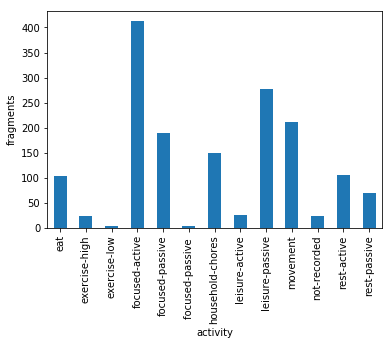

In [4]:
hp.plot_count(df, 'activity', exclude=['sleep'])

## 2A. Data preparation - Inserting labels for aggregating categories:

* 1: move vs still = exercise (high and low intensity), movement, household chores X *others*
* 2: sleep vs awake =  sleep X *others*
* 3: move vs sleep vs stand = Move (from 1) X Sleep (from 2) X *others*


In [5]:
movelist = ['exercise-high', 'exercise-low', 'movement', 'household-chores']
df = hp.add_partition(df, movelist, pname='moving', labelIn=1, labelOut=0)
    
sleeplist = ['sleep']
df = hp.add_partition(df, sleeplist, pname='sleeping', labelIn=1, labelOut=0)

activelist = ['rest-active', 'focused-active', 'leisure-active', 'eat']
df = hp.add_partition(df, activelist, pname='active', labelIn=1, labelOut=0)

passivelist = ['rest-passive', 'leisure-passive', 'focused-passive', 'focused-passive ']
df = hp.add_partition(df, passivelist, pname='passive', labelIn=1, labelOut=0)

df['focused'] = np.where(df['activity'].isin(['focused-passive', 'focused-passive ','focused-active']), 1, 0)
df['relaxed'] = np.where(df['activity'].isin(['rest-active', 'rest-passive', 'leisure-passive', 'leisure-active']), 1, 0)

df['lyingdown'] = np.where(df['posture'].isin(['lie', 'lying down']), 1, 0)
df['sitting'] = np.where(df['posture'].isin(['sit','sitting']), 1, 0)
df['standing'] = np.where(df['posture'].isin(['stand','standing', 'standing ']), 1, 0)


## 2B. Data preparation - scaling and splitting test and train datasets

In [6]:
features_all = ['hf', 'hfnu', 'lf', 'lf_hf', 'lfnu', 'mhr', 'mrri', 'nn50', 'pnn50', 'rmssd', 'sdnn', 'total_power', 'vlf']
features_red = ['hf', 'lf', 'vlf', 'lf_hf', 'mhr', 'mrri', 'pnn50', 'rmssd', 'sdnn']

one_hot_labels = ['moving', 'sleeping', 'sitting', 'standing', 'lyingdown', 'active', 'passive', 'focused', 'relaxed']
all_labels = ['activity', 'posture', 'moving', 'sleeping', 'sitting', 'standing', 'lyingdown', 'active', 'passive', 'focused', 'relaxed']

for l in all_labels:
    print(hp.count_by(df, l))

activity
eat                  103
exercise-high         24
exercise-low           4
focused-active       413
focused-passive      189
focused-passive        4
household-chores     150
leisure-active        27
leisure-passive      278
movement             212
not-recorded          25
rest-active          106
rest-passive          69
sleep               1090
Name: user, dtype: int64
posture
lie           682
lying down    448
posture        26
sit           823
sitting       325
stand         198
standing      184
standing        8
Name: user, dtype: int64
moving
0    2304
1     390
Name: user, dtype: int64
sleeping
0    1604
1    1090
Name: user, dtype: int64
sitting
0    1546
1    1148
Name: user, dtype: int64
standing
0    2304
1     390
Name: user, dtype: int64
lyingdown
0    1564
1    1130
Name: user, dtype: int64
active
0    2045
1     649
Name: user, dtype: int64
passive
0    2154
1     540
Name: user, dtype: int64
focused
0    2088
1     606
Name: user, dtype: int64
relaxed
0    

In [7]:
train, test = hp.preprocess(df, features_all)
ttu = [hp.preprocess(hp.user_data(df, user), features_all) for user in range(7)]
print ([(len(ttu[i][0]), len(ttu[i][1])) for i in range(7)])

2155 539
1028 258
242 61
352 89
43 11
161 41
180 46
145 37
[(1028, 258), (242, 61), (352, 89), (43, 11), (161, 41), (180, 46), (145, 37)]


## 3. SVM classification - Moving vs still (including sleep in still activities)

In [8]:
label='activity'
#c1, c2, gamma = hp.model_selection_svm(df, feature_list, labelName=label)
c1, c2, gamma = (10, 10, 0.1)

### 3A. For all users combined

In [9]:
c1 = 10
c2 = 10
gamma = 0.1
for label in all_labels:
    clf_svm = hp.clf_svm_rbf(train, features_all, labelName=label, C=c2, gamma=gamma)
    print(label, ': ', hp.report_test(clf_svm, test, features_all, labels=[label], print_report=False, plot_report=False))

C:\Users\Ju\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 13, does not match size of target_names, 2
  .format(len(labels), len(target_names))
C:\Users\Ju\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


activity :  0.400742115028


C:\Users\Ju\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 8, does not match size of target_names, 2
  .format(len(labels), len(target_names))


posture :  0.285714285714
moving :  0.860853432282
sleeping :  0.599257884972
sitting :  0.578849721707
standing :  0.846011131725
lyingdown :  0.580705009276
active :  0.786641929499
passive :  0.760667903525
focused :  0.786641929499
relaxed :  0.805194805195


### 3B. For each user (SVM moving x still)

In [10]:
label='moving'
for user in [0,1,2,3,5]:
    train_u, test_u = ttu[user]
    print ('---------------- User: ', user, ' ----------------------')
    clf_svm = hp.clf_svm_rbf(train_u, features_all, labelName=label, C=c2, gamma=gamma)
    print(hp.report_test(clf_svm, test_u, features_all, labels=[label], print_report=True, plot_report=False), '\n')

---------------- User:  0  ----------------------
             precision    recall  f1-score   support

 not moving       0.79      1.00      0.89       205
     moving       0.00      0.00      0.00        53

avg / total       0.63      0.79      0.70       258

0.794573643411 

---------------- User:  1  ----------------------
             precision    recall  f1-score   support

 not moving       0.95      1.00      0.97        58
     moving       0.00      0.00      0.00         3

avg / total       0.90      0.95      0.93        61

0.950819672131 

---------------- User:  2  ----------------------
             precision    recall  f1-score   support

 not moving       0.75      1.00      0.86        67
     moving       0.00      0.00      0.00        22

avg / total       0.57      0.75      0.65        89

0.752808988764 

---------------- User:  3  ----------------------
             precision    recall  f1-score   support

 not moving       0.64      1.00      0.78        

C:\Users\Ju\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 3C. For each user (SVM awake  x sleep)

In [11]:
label='sleeping'
for user in df.loc[df[label]==1].user.unique(): #users that have sleep data
    train_u, test_u = ttu[user]
    print ('---------------- User: ', user, ' ----------------------')
    clf_svm = hp.clf_svm_rbf(train_u, features_all, labelName=label, C=c2, gamma=gamma)
    print(hp.report_test(clf_svm, test_u, features_all, labels=[label], print_report=True, plot_report=False), '\n')

---------------- User:  0  ----------------------
              precision    recall  f1-score   support

not sleeping       0.54      1.00      0.70       139
    sleeping       0.00      0.00      0.00       119

 avg / total       0.29      0.54      0.38       258

0.538759689922 

---------------- User:  1  ----------------------
              precision    recall  f1-score   support

not sleeping       0.82      1.00      0.90        50
    sleeping       0.00      0.00      0.00        11

 avg / total       0.67      0.82      0.74        61

0.819672131148 

---------------- User:  2  ----------------------
              precision    recall  f1-score   support

not sleeping       0.87      1.00      0.93        77
    sleeping       0.00      0.00      0.00        12

 avg / total       0.75      0.87      0.80        89

0.865168539326 

---------------- User:  4  ----------------------
              precision    recall  f1-score   support

not sleeping       0.00      0.00    

C:\Users\Ju\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 5. Random Forest classifier 

### 4A. For each label separately

In [12]:
for label in all_labels:
    clf = hp.clf_rf(train, features_all, labels=[label])
    print(label, ': ', clf.score(X=test[features_all], y=test[label]))
    

activity :  0.589981447124
posture :  0.673469387755
moving :  0.909090909091
sleeping :  0.873840445269
sitting :  0.795918367347
standing :  0.901669758813
lyingdown :  0.897959183673
active :  0.820037105751
passive :  0.766233766234
focused :  0.810760667904
relaxed :  0.814471243043


moving :  0.909090909091
sleeping :  0.871985157699
sitting :  0.792207792208
standing :  0.894248608534
lyingdown :  0.879406307978
active :  0.807050092764
passive :  0.775510204082
focused :  0.805194805195
relaxed :  0.810760667904


<Container object of 9 artists>

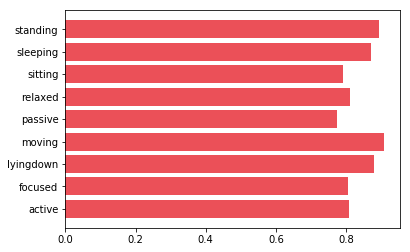

In [13]:
scores = []
for label in one_hot_labels:
    clf = hp.clf_rf(train, features_red, labels=[label])
    score = clf.score(X=test[features_red], y=test[label])
    print(label, ': ', score)
    scores.append(score)
    #print(hp.report_test(clf, test, features_red, labels=[label], print_report=False, plot_report=False), '\n')
    
plt.barh(one_hot_labels, scores, align='center', alpha=1, color='#eb5058')

In [17]:
ul = [[] for i in range(len(one_hot_labels))]
for user in [0,1,2,4,5,6]:
    print('\n-------------- USER: ', user, '--------------')
    train_u, test_u = ttu[user]    
    for i,label in enumerate(one_hot_labels):
        clf = hp.clf_rf(train_u, features_red, labels=[label])        
        score = clf.score(X=test_u[features_red], y=test_u[label])
        print(label, ': ', score)
        ul[i].append(score)
        


-------------- USER:  0 --------------
moving :  0.87984496124
sleeping :  0.887596899225
sitting :  0.763565891473
standing :  0.868217054264
lyingdown :  0.891472868217
active :  0.821705426357
passive :  0.817829457364
focused :  0.779069767442
relaxed :  0.899224806202

-------------- USER:  1 --------------
moving :  0.983606557377
sleeping :  0.983606557377
sitting :  0.934426229508
standing :  0.983606557377
lyingdown :  0.934426229508
active :  0.770491803279
passive :  0.770491803279
focused :  0.72131147541
relaxed :  0.770491803279

-------------- USER:  2 --------------
moving :  0.820224719101
sleeping :  0.966292134831
sitting :  0.786516853933
standing :  0.797752808989
lyingdown :  0.943820224719
active :  0.651685393258
passive :  0.797752808989
focused :  0.685393258427
relaxed :  0.842696629213

-------------- USER:  4 --------------
moving :  1.0
sleeping :  0.780487804878
sitting :  0.878048780488
standing :  1.0
lyingdown :  0.853658536585
active :  1.0
passive :

[0.94365618454728339, 0.91733330792420109, 0.87025786326804477, 0.93346837719459497, 0.91823238504392668, 0.84871604231933861, 0.83989429157243467, 0.85078223669959707, 0.85644631524491821]


<Container object of 9 artists>

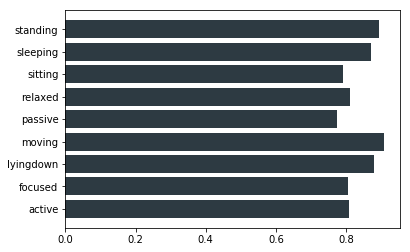

In [18]:
print([np.mean(l) for l in ul])
plt.barh(one_hot_labels, scores, align='center', alpha=1, color='#2d3a42')

### 4B. For multi-1-hot encoded labels

['moving', 'sleeping', 'sitting', 'standing', 'lyingdown', 'active', 'passive', 'focused', 'relaxed']
['hf', 'hfnu', 'lf', 'lf_hf', 'lfnu', 'mhr', 'mrri', 'nn50', 'pnn50', 'rmssd', 'sdnn', 'total_power', 'vlf']


C:\Users\Ju\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ju\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

     moving       0.00      0.00      0.00         0
   sleeping       0.89      0.80      0.84       220
    sitting       0.83      0.91      0.87       221
   standing       1.00      0.20      0.33         5
  lyingdown       0.91      0.80      0.85       233
     active       0.55      0.45      0.49       121
    passive       0.49      0.30      0.37       111
    focused       0.58      0.46      0.52       108
    relaxed       0.50      0.28      0.36       101

avg / total       0.74      0.65      0.69      1120

[0.0, 0.0, 0.0]
[0.89, 0.8, 0.84]
[0.83, 0.91, 0.87]
[1.0, 0.2, 0.33]
[0.91, 0.8, 0.85]
[0.55, 0.45, 0.49]
[0.49, 0.3, 0.37]
[0.58, 0.46, 0.52]
[0.5, 0.28, 0.36]


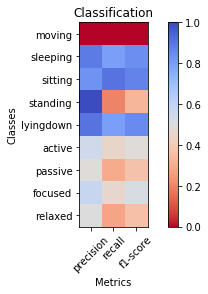

0.48590021692 



In [33]:
clf = hp.clf_rf(train, features_all, labels=one_hot_labels)
print(hp.report_test(clf, test, features_all, labels=one_hot_labels, print_report=True, plot_report=True), '\n')

In [31]:
for user in [0,1,2,5,6]: 
    print('-------------- USER: ', user, '--------------')
    dfu = hp.user_data(df, user)
    clf = hp.clf_rf(train, features_red, labels=one_hot_labels)
    print(clf.score(X=test[features_red], y=test[one_hot_labels]))
    
    

-------------- USER:  0 --------------
['moving', 'sleeping', 'sitting', 'standing', 'lyingdown', 'active', 'passive', 'focused', 'relaxed']
['hf', 'lf', 'vlf', 'lf_hf', 'mhr', 'mrri', 'pnn50', 'rmssd', 'sdnn']
0.520607375271
-------------- USER:  1 --------------
['moving', 'sleeping', 'sitting', 'standing', 'lyingdown', 'active', 'passive', 'focused', 'relaxed']
['hf', 'lf', 'vlf', 'lf_hf', 'mhr', 'mrri', 'pnn50', 'rmssd', 'sdnn']
0.51409978308
-------------- USER:  2 --------------
['moving', 'sleeping', 'sitting', 'standing', 'lyingdown', 'active', 'passive', 'focused', 'relaxed']
['hf', 'lf', 'vlf', 'lf_hf', 'mhr', 'mrri', 'pnn50', 'rmssd', 'sdnn']
0.505422993492
-------------- USER:  5 --------------
['moving', 'sleeping', 'sitting', 'standing', 'lyingdown', 'active', 'passive', 'focused', 'relaxed']
['hf', 'lf', 'vlf', 'lf_hf', 'mhr', 'mrri', 'pnn50', 'rmssd', 'sdnn']
0.507592190889
-------------- USER:  6 --------------
['moving', 'sleeping', 'sitting', 'standing', 'lyingdown',

In [21]:
df_nm = hp.filter_out(df, 'moving', [1])
df_nm.sample(20)
train, test = hp.preprocess(df_nm, features_red)
for label in all_labels:
    clf = hp.clf_rf(train, features_red, labels=[label])
    print(label, ': ', clf.score(X=test[features_red], y=test[label]))

1843 461
activity :  0.60737527115
posture :  0.770065075922
moving :  1.0
sleeping :  0.872017353579
sitting :  0.8568329718
standing :  0.991323210412
lyingdown :  0.863340563991
active :  0.770065075922
passive :  0.770065075922
focused :  0.793926247289
relaxed :  0.789587852495


In [35]:
#hp.run_rf(df_wake, feature_list, labels, print_report=True, plot_report=True)

In [36]:
for user in [0,1,2,5,6]: 
    print('-------------- USER: ', user, '--------------')
    dfu = hp.user_data(df_wake, user)
    uscore = hp.run_rf(dfu, feature_list, labels, plot_report=True)
    print(uscore, '\n\n')

-------------- USER:  0 --------------


NameError: name 'df_wake' is not defined